Rank-1 reconstruction MSE: 0.0562
Rank-2 reconstruction MSE: 0.0546
Rank-5 reconstruction MSE: 0.0509

Explained variance ratios (first 5):
  Mode 1: evr=0.130, cumulative=0.130
  Mode 2: evr=0.025, cumulative=0.155
  Mode 3: evr=0.020, cumulative=0.175
  Mode 4: evr=0.019, cumulative=0.194
  Mode 5: evr=0.019, cumulative=0.213

EOF orthonormality error ||V^T V - I||_F: 1.73e-14


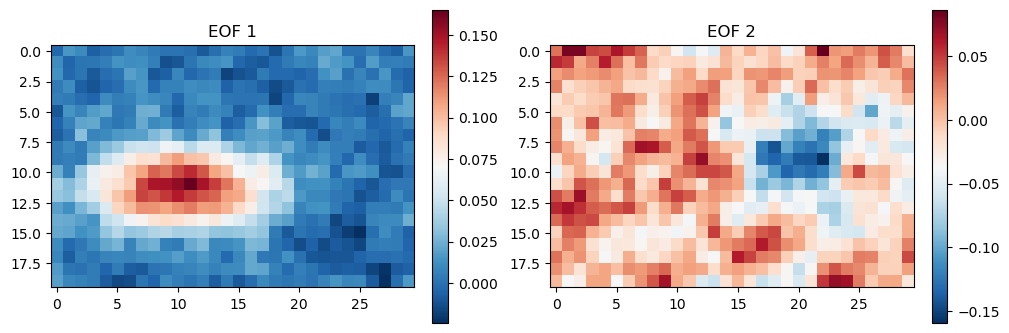

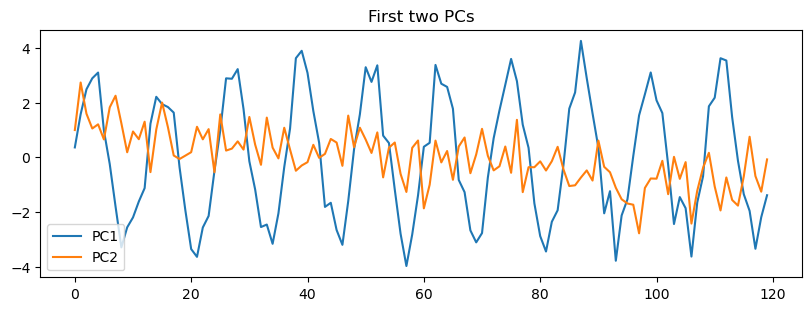

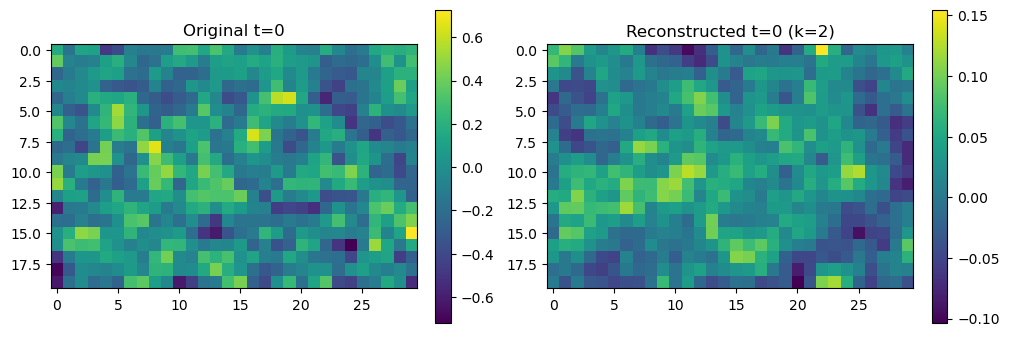

In [2]:
# eof_demo.py
# Fundamental EOF demonstration using SVD on a synthetic spatiotemporal field
# Python 3.x; only requires numpy. Optional plots use matplotlib.

import numpy as np

# Optional plotting; set to True if matplotlib is available
DO_PLOT = False
try:
    import matplotlib.pyplot as plt  # noqa: F401
    DO_PLOT = True
except Exception:
    DO_PLOT = False

def make_gaussian_blob(nx, ny, cx, cy, sx, sy):
    """Create a 2D Gaussian blob centered at (cx, cy) with scales (sx, sy)."""
    x = np.linspace(-1, 1, nx)
    y = np.linspace(-1, 1, ny)
    Xg, Yg = np.meshgrid(x, y, indexing='xy')
    return np.exp(-(((Xg - cx) ** 2) / (2 * sx ** 2) + ((Yg - cy) ** 2) / (2 * sy ** 2)))

def build_synthetic_field(T=120, nx=30, ny=20, seed=42):
    """
    Build a synthetic field with two spatial patterns and two temporal drivers:
    - Mode A: seasonal sinusoid times spatial blob A
    - Mode B: linear trend times spatial blob B
    plus spatially correlated noise.
    """
    rng = np.random.default_rng(seed)

    # Spatial patterns (normalized to unit norm to control amplitudes cleanly)
    blob_A = make_gaussian_blob(nx, ny, cx=-0.3, cy=0.2, sx=0.35, sy=0.25)
    blob_B = make_gaussian_blob(nx, ny, cx=0.4, cy=-0.1, sx=0.25, sy=0.35)
    blob_A = blob_A / np.linalg.norm(blob_A)
    blob_B = blob_B / np.linalg.norm(blob_B)

    # Time axis and temporal signals
    t = np.arange(T)
    seasonal = np.sin(2 * np.pi * t / 12.0)  # seasonal oscillation (period 12)
    trend = np.linspace(0.0, 1.0, T)         # linear trend

    # Amplitudes
    amp_A = 3.0
    amp_B = 2.0

    # Build clean signal (T, ny, nx)
    field_clean = (amp_A * seasonal[:, None, None] * blob_A[None, :, :]) + \
                  (amp_B * trend[:, None, None]    * blob_B[None, :, :])

    # Add spatially correlated noise
    # Create low-pass noise by smoothing white noise with a simple kernel
    kernel = np.array([[0.05, 0.1, 0.05],
                       [0.1,  0.4, 0.1 ],
                       [0.05, 0.1, 0.05]])
    kernel = kernel / kernel.sum()

    def smooth2d(A):
        """Apply 2D smoothing using a 3x3 kernel to reduce high-frequency noise."""
        B = np.pad(A, ((1, 1), (1, 1)), mode='edge')
        out = np.zeros_like(A)
        # CORRECTED: Use A.shape[0] and A.shape[1] instead of A.shape
        for i in range(A.shape[0]):  # iterate over rows
            for j in range(A.shape[1]):  # iterate over columns
                window = B[i:i+3, j:j+3]
                out[i, j] = np.sum(window * kernel)
        return out

    noise = np.stack([smooth2d(rng.standard_normal((ny, nx))) for _ in range(T)], axis=0)
    noise *= 0.5  # noise scale

    field = field_clean + noise  # (T, ny, nx)
    return field, field_clean, seasonal, trend, blob_A, blob_B, t

def eof_via_svd(field):
    """
    Compute EOFs via SVD on centered anomalies:
      X: T x N, with T times and N = ny*nx grid points
      SVD: X = U S V^T
      EOFs (spatial patterns) are columns of V (N x K)
      PCs (time series) are U @ S (T x K)
      Explained variance ratio from S^2 / sum(S^2)
    """
    T, ny, nx = field.shape
    N = ny * nx

    # Reshape to matrix X (T, N)
    X = field.reshape(T, N)

    # Remove temporal mean at each grid point (column-wise) to get anomalies
    X = X - X.mean(axis=0, keepdims=True)

    # SVD
    U, s, Vt = np.linalg.svd(X, full_matrices=False)  # U: (T,K), s: (K,), Vt: (K,N)
    EOFs = Vt.T                                      # (N, K)
    PCs = U * s                                      # (T, K)

    # Explained variance ratios
    eigvals = s**2
    evr = eigvals / eigvals.sum()

    return EOFs, PCs, evr, (U, s, Vt), (ny, nx)

def reconstruct(U, s, Vt, k):
    """Rank-k reconstruction from leading k singular triplets."""
    Uk = U[:, :k]
    sk = s[:k]
    Vtk = Vt[:k, :]
    return Uk @ np.diag(sk) @ Vtk  # (T, N)

def main():
    # 1) Build data
    field, field_clean, seasonal, trend, blob_A, blob_B, t = build_synthetic_field()

    # 2) EOF decomposition
    EOFs, PCs, evr, (U, s, Vt), (ny, nx) = eof_via_svd(field)
    T = field.shape[0]  # CORRECTED: get first dimension only
    N = ny * nx

    # 3) Checks: orthonormal EOFs (V^T V = I)
    V = EOFs
    VT_V = V.T @ V
    ortho_err = np.linalg.norm(VT_V - np.eye(VT_V.shape[0]))  # CORRECTED: specify dimension

    # 4) Reconstruction test for k=1,2,5
    X = field.reshape(T, N)
    X = X - X.mean(axis=0, keepdims=True)
    for k in [1, 2, 5]:
        Xk = reconstruct(U, s, Vt, k)
        mse = np.mean((X - Xk)**2)
        print(f"Rank-{k} reconstruction MSE: {mse:.4f}")

    # 5) Explained variance
    cum_evr = np.cumsum(evr)
    print("\nExplained variance ratios (first 5):")
    for i in range(5):
        print(f"  Mode {i+1}: evr={evr[i]:.3f}, cumulative={cum_evr[i]:.3f}")

    print(f"\nEOF orthonormality error ||V^T V - I||_F: {ortho_err:.2e}")

    # 6) Optional: simple plots if matplotlib is available
    if DO_PLOT:
        # First two EOFs as maps
        fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
        for i, ax in enumerate(axs):
            eof_map = EOFs[:, i].reshape(ny, nx)
            im = ax.imshow(eof_map, cmap='RdBu_r')
            ax.set_title(f'EOF {i+1}')
            plt.colorbar(im, ax=ax, shrink=0.8)

        # First two PCs
        fig2, ax2 = plt.subplots(figsize=(8, 3), constrained_layout=True)
        ax2.plot(PCs[:, 0], label='PC1')
        ax2.plot(PCs[:, 1], label='PC2')
        ax2.legend()
        ax2.set_title('First two PCs')

        # Reconstruction vs original (k=2)
        X2 = reconstruct(U, s, Vt, k=2)
        field2 = X2.reshape(-1, ny, nx) + field.mean(axis=0, keepdims=True)
        fig3, axs3 = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
        im0 = axs3[0].imshow(field[0], cmap='viridis'); axs3[0].set_title('Original t=0')  # CORRECTED: specify time index
        im1 = axs3[1].imshow(field2[0], cmap='viridis'); axs3[1].set_title('Reconstructed t=0 (k=2)')  # CORRECTED: specify time index
        plt.colorbar(im0, ax=axs3[0], shrink=0.8)
        plt.colorbar(im1, ax=axs3[1], shrink=0.8)
        plt.show()

if __name__ == "__main__":
    main()